In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
try:
    import importlib
    importlib.reload(h)
    importlib.reload(f)
    importlib.reload(d)
except NameError: # It hasn't been imported yet
    import helpers as h
    import implementations as f
    import data_processing as d

# Data preprocessing and feature selections

## Data preprocessing

#For this to work, the data folder needs to be one level above the project folder and the folder name needs
#to be 'data'
data_folder = '../data/'
x_train, x_test, y_train, train_ids, test_ids = h.load_csv_data(data_folder)


In [2]:
np.random.seed(0)

In [3]:
x_train, x_test, y_train, train_ids, test_ids = h.load_csv_data("../data")

In [4]:
np.save('../data/y_train.npy', y_train)
np.save('../data/x_train.npy', x_train)
np.save('../data/x_test.npy', x_test)
np.save('../data/train_ids.npy', train_ids)
np.save('../data/test_ids.npy', test_ids)

In [3]:
x_train = np.load("../data/x_train.npy")
x_test = np.load("../data/x_test.npy")
y_train = np.load("../data/y_train.npy")
train_ids = np.load("../data/train_ids.npy")
test_ids = np.load("../data/test_ids.npy")

In [5]:
#features_named all the features names and remove the ID column
features_name = np.genfromtxt('../data/x_train.csv', delimiter=',', dtype=str, max_rows=1)[1:] 
features_name

array(['_STATE', 'FMONTH', 'IDATE', 'IMONTH', 'IDAY', 'IYEAR', 'DISPCODE',
       'SEQNO', '_PSU', 'CTELENUM', 'PVTRESD1', 'COLGHOUS', 'STATERES',
       'CELLFON3', 'LADULT', 'NUMADULT', 'NUMMEN', 'NUMWOMEN', 'CTELNUM1',
       'CELLFON2', 'CADULT', 'PVTRESD2', 'CCLGHOUS', 'CSTATE', 'LANDLINE',
       'HHADULT', 'GENHLTH', 'PHYSHLTH', 'MENTHLTH', 'POORHLTH',
       'HLTHPLN1', 'PERSDOC2', 'MEDCOST', 'CHECKUP1', 'BPHIGH4', 'BPMEDS',
       'BLOODCHO', 'CHOLCHK', 'TOLDHI2', 'CVDSTRK3', 'ASTHMA3', 'ASTHNOW',
       'CHCSCNCR', 'CHCOCNCR', 'CHCCOPD1', 'HAVARTH3', 'ADDEPEV2',
       'CHCKIDNY', 'DIABETE3', 'DIABAGE2', 'SEX', 'MARITAL', 'EDUCA',
       'RENTHOM1', 'NUMHHOL2', 'NUMPHON2', 'CPDEMO1', 'VETERAN3',
       'EMPLOY1', 'CHILDREN', 'INCOME2', 'INTERNET', 'WEIGHT2', 'HEIGHT3',
       'PREGNANT', 'QLACTLM2', 'USEEQUIP', 'BLIND', 'DECIDE', 'DIFFWALK',
       'DIFFDRES', 'DIFFALON', 'SMOKE100', 'SMOKDAY2', 'STOPSMK2',
       'LASTSMK2', 'USENOW3', 'ALCDAY5', 'AVEDRNK2', 'DRNK3GE5',
    

In [6]:
features_name[26]

'GENHLTH'

## Feature selection

one paper on internet suggests to use these features : 

 _RFHYPE5, TOLDHI2, _CHOLCHK, _BMI5, SMOKE100, CVDSTRK3, DIABETE3, _TOTINDA, _FRTLT1, _VEGLT1, _RFDRHV5, HLTHPLN1, MEDCOST, GENHLTH, MENTHLTH, PHYSHLTH, DIFFWALK, SEX, _AGEG5YR, EDUCA, and INCOME2

We apply a mask to get only these important features.

Then using we use our preprocessing function. For feature where the answer is yes or no we make the data binary, ordinal (categorical) variables ares changed to 0,1,2,...,Missing values are replace by the mean of the column.


In [7]:
#Select the important features
features_list = ['_RFHYPE5', 'TOLDHI2', '_CHOLCHK', '_BMI5', 'SMOKE100', 'CVDSTRK3', 'DIABETE3', '_TOTINDA', '_FRTLT1', '_VEGLT1', '_RFDRHV5', 
                 'HLTHPLN1', 'MEDCOST', 'GENHLTH', 'MENTHLTH', 'PHYSHLTH', 'DIFFWALK', 'SEX', '_AGEG5YR', 'EDUCA', 'INCOME2', ]


In [8]:
trainMask, testMask = f.masking((x_train, x_test), features_name, features_list)
trainProcessed = d.feature_processing_test(trainMask)

#Test data Processing 
testProcessed  = d.feature_processing_test(testMask)


x_train_algo = f.replaceMissingValuesMean(trainMask)
x_test_algo = f.replaceMissingValuesMean(testMask)


yo
328135


In [9]:
heart_dis = x_train_algo[y_train == 1]
non_hd = x_train_algo[y_train == -1]

random_indices_nonhd = np.random.choice(range(len(non_hd)), len(heart_dis), replace=False)

train_sample = np.concatenate((heart_dis, non_hd[random_indices_nonhd]), axis=0)
train_sample.shape

(57950, 21)

In [10]:
y_train_sample = np.concatenate((np.ones(len(heart_dis)), -np.ones(len(heart_dis))), axis=0)

#shuffle both train_sample and y_train_sample the same way

shuffle_indices = np.random.permutation(len(train_sample))
train_sample = train_sample[shuffle_indices]
y_train_sample = y_train_sample[shuffle_indices]

print(train_sample.shape, y_train_sample.shape)

(57950, 21) (57950,)


# Processing 

### Now that the preprocessing has been done, we can format the data to be used by the algorithms

In [11]:
tX_train = np.c_[np.ones((len(train_sample), 1)), train_sample]
tX_test = np.c_[np.ones((len(x_test_algo), 1)), x_test_algo]

### Initialisation of set parameters

In [12]:
initial_w = [random.choice([1, -1]) for i in range(len(tX_train[0]))]
max_iter = 500

### Separation of the dataset in a test/train set

In [121]:
#tX_train_train = tX_train[:int(len(tX_train)*0.7)]
#y_train_train = y_train_sample[:int(len(tX_train)*0.7)]
#tX_train_validation = tX_train[int(len(tX_train)*0.7):]
#y_train_validation = y_train_sample[int(len(tX_train)*0.7):]

split=int((len(tX_train))*0.6)
tX_train_train, tX_train_validation = np.split(tX_train,[split])
y_train_train, y_train_validation = np.split(y_train_sample,[split])


## Plotting functions

In [122]:
def loss_progression(w):
    # Plot progression of the weights in function of the iteration and progression on the test set
    plt.figure(0)
    plt.plot(w)

## And then, we can run the algorithms

1. MSE gradient descent

In [123]:
#Compute gradient descent with MSE as loss function (see functions.py for the function)

w_mse_gd, loss_mse_gd = f.mean_squared_error_gd(y_train_train, tX_train_train, initial_w, 2000, 0.005)
print(loss_mse_gd)

Gradient Descent(1999/2000): Final loss=0.3873215468557408
[38.98634435 27.00502941 20.68981562 ...  0.38745794  0.3873897
  0.38732155]


In [124]:
loss_test_set = []
for w in w_mse_gd:
    loss_test_set.append(f.compute_mse(y_train_validation, tX_train_validation, w))

print(loss_test_set)

[39.55184961408548, 27.28003466872681, 20.882837885353428, 17.071232755536695, 14.674927350221285, 13.057931529932821, 11.889699694543244, 10.985019240962032, 10.242775598875882, 9.60614529662843, 9.043023423209533, 8.534727530037902, 8.070026672346879, 7.641821126709142, 7.245342556540249, 6.877160557911301, 6.534636472084351, 6.215619646074962, 5.918277161583506, 5.640996699085751, 5.382329809481112, 5.140957598356995, 4.915668972323869, 4.705346019086587, 4.508953523208213, 4.325530949933845, 4.154185962015145, 3.9940889385437535, 3.8444681889421837, 3.7046056803198137, 3.5738331668060286, 3.451528649574151, 3.3371131194847763, 3.2300475480116475, 3.129830100475999, 3.035993550897054, 2.9481028812533014, 2.8657530503693605, 2.7885669194133853, 2.716193322351541, 2.648305270801306, 2.5845982836396213, 2.52478883250761, 2.468612895043725, 2.4158246082932497, 2.366195015298414, 2.319510898380014, 2.275573693085604, 2.234198477206367, 2.1952130296589676, 2.15845695439335, 2.123780864825

Text(0.5, 0.98, 'Loss of train and validation test')

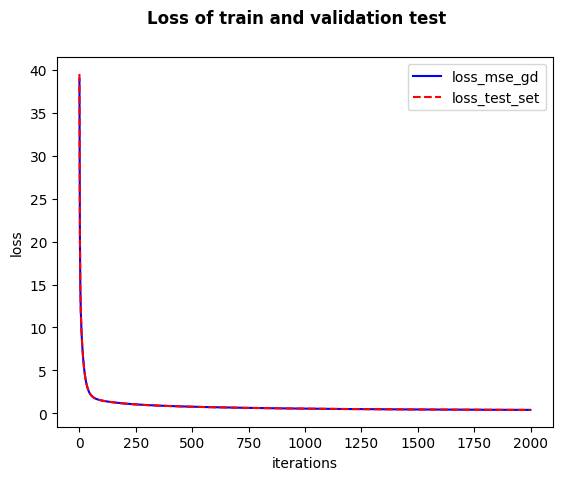

In [137]:
fig, ax = plt.subplots()
ax.plot(loss_mse_gd, '-b', label='loss_mse_gd')
ax.plot(loss_test_set, '--r', label='loss_test_set')
leg = ax.legend(frameon=True)
plt.xlabel('iterations')
plt.ylabel('loss')
fig.suptitle('Loss of train and validation test', fontweight='bold')

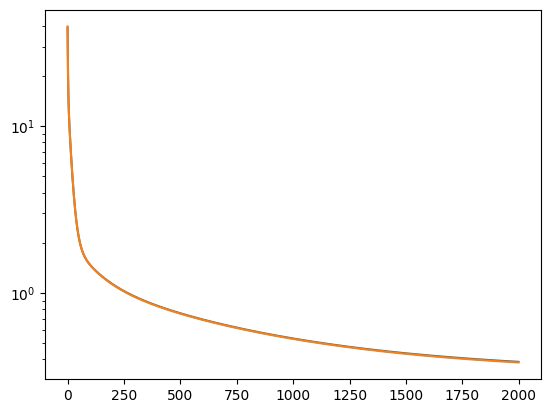

In [127]:
plt.figure(0)
plt.semilogy(loss_mse_gd)
plt.semilogy(loss_test_set)
plt.show()

In [19]:
y_pred = tX_train_test.dot(w_mse_gd[-1, :])
y_pred = np.where(y_pred > 0, 1, -1)

_,_,_,_,f1 = f.confusion_matrix(y_train_test, y_pred)

print("Accuracy: ", np.sum(y_pred == y_train_test)/len(y_train_test))
print("F1 score: ", f1)


Accuracy:  0.6719585849870578
F1 score:  0.6767556538003741


In [ ]:
#h.create_csv_submission(test_ids, y_test_rounded, 'submission_gd.csv')

In [20]:
#Test the model on the test sample. Do we need to standardize ?

y_test = tX_test.dot(w_mse_gd[-1, :])
y_test_rounded = np.where(y_test > 0, 1, -1) 

print('weights = \n\n', w_mse_gd[-1, :],'\n\n Loss = ', loss_mse_gd[-1],'\n\n*****************************************************************************',
      ' \n\n Train sample : \n', 'Heart attack rate = ', np.count_nonzero(y_train == 1)/len(y_train), '\n \n Test sample : \n', 'Heart attack rate = ', np.count_nonzero(y_test_rounded == 1)/len(y_test_rounded))

weights = 

 [ 0.80149262  0.2014374   0.01302756  0.00108982  0.66443674 -0.78482714
 -0.60959541  0.4871754  -0.02636918 -0.54735932  0.01660288 -0.0187044
  0.35443277  0.40046098 -0.67968514 -0.75147237  0.12549661 -1.03838416
 -1.00734007  0.31870079  0.45136775 -0.5416913 ] 

 Loss =  0.60928454990739 

*****************************************************************************  

 Train sample : 
 Heart attack rate =  0.08830207079403295 
 
 Test sample : 
 Heart attack rate =  0.37923184523537423


Lets run some cross validation to see the best initial weights (as a function of the proportion of 1, -1 and 0)


2. MSE SGD

In [141]:
w_mse_sgd, loss_mse_sgd = f.mean_squared_error_sgd(y_train_train, tX_train_train, initial_w, 4000, 0.001)

SGD iter. 3999/3999: loss=0.0033550053543519426, w0=-1.1757972488464472, w1=0.040362628062314575


In [160]:
def plotLossMSE(weights, loss, y, x ):
    loss_test_set = []

    for w in weights:
        loss_test_set.append(f.compute_mse(y, x, w))

    plt.figure(0)
    plt.semilogy(loss)
    plt.semilogy(loss_test_set)
    plt.ylabel("loss")
    plt.xlabel("iterations")
    plt.title("??",fontweight='bold')
    plt.show()


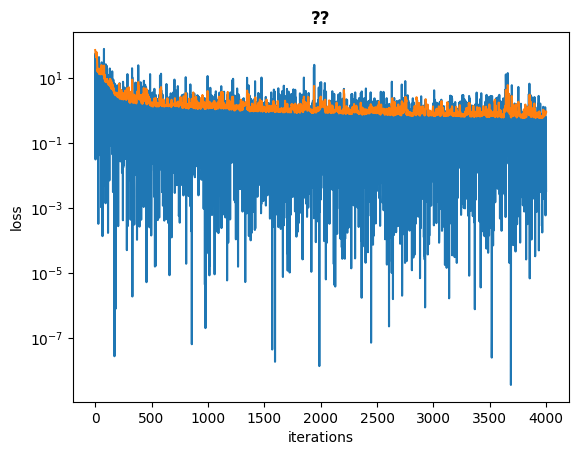

In [161]:
plotLossMSE(w_mse_sgd, loss_mse_sgd, y_train_validation, tX_train_validation)

In [23]:
y_pred = tX_train_test.dot(w_mse_sgd[-1])
y_pred = np.where(y_pred > 0, 1, -1)

_,_,_,_,f1 = f.confusion_matrix(y_train_test, y_pred)

print("Accuracy: ", np.sum(y_pred == y_train_test)/len(y_train_test))

print("F1 score: ", f1)

Accuracy:  0.6600517687661778
F1 score:  0.6557548928238583


In [24]:
y_test_sgd = tX_test.dot(w_mse_sgd[-1])
y_test_rounded_sgd = np.where(y_test_sgd > 0, 1, -1)

print('weights = \n', w_mse_sgd[-1],'\n Loss = ', loss_mse_sgd[-1],'\n*****************************************************************************',
      ' \n Train sample : \n', 'Heart attack rate = ', np.count_nonzero(y_train == 1)/len(y_train), '\n \n Test sample : \n', 'Heart attack rate = ', np.count_nonzero(y_test_rounded_sgd == 1)/len(y_test_rounded_sgd))

weights = 
 [ 0.8072235   0.17829798  0.04270264 -0.05902474  0.65553781 -0.76232758
 -0.65479032  0.45240915 -0.00414041 -0.58232014  0.03714766 -0.04529378
  0.38748012  0.42249881 -0.64193117 -0.71568076  0.12850286 -1.03638318
 -1.00777178  0.32295018  0.45368291 -0.59878596] 
 Loss =  0.023499469921802945 
*****************************************************************************  
 Train sample : 
 Heart attack rate =  0.08830207079403295 
 
 Test sample : 
 Heart attack rate =  0.3561469751963357


3. Least squares

In [25]:
w_ls, loss_ls = f.least_squares(y_train_train, tX_train_train)

In [26]:
y_pred = tX_train_test.dot(w_ls)
y_pred = np.where(y_pred > 0, 1, -1)

_,_,_,_,f1 = f.confusion_matrix(y_train_test, y_pred)

print("Accuracy: ", np.sum(y_pred == y_train_test)/len(y_train_test))

print("F1 score: ", f1)

Accuracy:  0.7725050330744895
F1 score:  0.781262098335269


In [27]:

y_test_ls = tX_test.dot(w_ls)
y_test_ls = np.where(y_test_ls > 0, 1, -1)

print('weights = \n', w_ls,'\n Loss = ', loss_ls,'\n*****************************************************************************',
      ' \n Train sample : \n', 'Heart attack rate = ', np.count_nonzero(y_train == 1)/len(y_train), '\n \n Test sample : \n', 'Heart attack rate = ', np.count_nonzero(y_test_ls == 1)/len(y_test_ls))

weights = 
 [-0.1509423   0.15791376  0.00038506  0.00197446 -0.07689012 -0.06851134
 -0.23849256 -0.3276565  -0.06786121 -0.24931674 -0.0082664  -0.01818973
 -0.15653227 -0.12240613 -0.23583667  0.17746014  0.0713944  -0.20171093
  0.06887195 -0.00450336 -0.0174636  -0.00068118] 
 Loss =  0.3226991227822127 
*****************************************************************************  
 Train sample : 
 Heart attack rate =  0.08830207079403295 
 
 Test sample : 
 Heart attack rate =  0.30730761846423904


4. Ridge regression

In [28]:
w_ridge, loss_ridge = f.ridge_regression(y_train_train, tX_train_train, 0.2)

In [29]:
y_test_ridge = tX_test.dot(w_ridge)
y_test_ridge = np.where(y_test_ridge > 0, 1, -1)

print('weights = \n', w_ridge,'\n Loss = ', loss_ridge,'\n*****************************************************************************',
      ' \n Train sample : \n', 'Heart attack rate = ', np.count_nonzero(y_train == 1)/len(y_train), '\n \n Test sample : \n', 'Heart attack rate = ', np.count_nonzero(y_test_ridge == 1)/len(y_test_ridge))

weights = 
 [-0.03245025  0.09951002  0.00597439  0.00184978 -0.02091555 -0.03101642
 -0.11907935 -0.09294309 -0.09552706 -0.11423584 -0.05307825 -0.03750972
 -0.07809128 -0.0730623  -0.1273555   0.02142743  0.07810166 -0.00703158
 -0.02253884 -0.00602203 -0.00727936 -0.00252951] 
 Loss =  0.33938150406194895 
*****************************************************************************  
 Train sample : 
 Heart attack rate =  0.08830207079403295 
 
 Test sample : 
 Heart attack rate =  0.3278234395999232


5. Logistic regression

In [30]:
y_train_processed_logreg = np.where(y_train_train == 1, 1, 0)
y_train_train_lg = np.where(y_train_train == 1, 1, 0)

In [31]:
w_logreg, loss_logreg = f.logistic_regression(y_train_train_lg, tX_train_train,initial_w,1000, 0.1)

Gradient Descent(999/999): loss=1.0013639412235138, w0=0.48879452721559036, w1=0.8163386883054633


In [32]:
y_pred = tX_train_test.dot(w_logreg[-1, :])
y_pred = np.where(y_pred > 0.5, 1, 0)
y_pred = np.where(y_pred == 1, 1, -1)

_,_,_,_,f1 = f.confusion_matrix(y_train_test, y_pred)

print("Accuracy: ", np.sum(y_pred == y_train_test)/len(y_train_test))

print("F1 score: ", f1)

Accuracy:  0.7395455852746621
F1 score:  0.782767223181731


In [33]:
y_test_logreg = tX_test.dot(w_logreg[-1, :])
y_test_logreg = np.where(y_test_logreg > 0.5, 1, 0)

print('weights = \n', w_logreg[-1,:],'\n Loss = ', loss_logreg[-1],'\n*****************************************************************************',
        ' \n Train sample : \n', 'Heart attack rate = ', np.count_nonzero(y_train== 1)/len(y_train), '\n \n Test sample : \n', 'Heart attack rate = ', np.count_nonzero(y_test_logreg == 1)/len(y_test_logreg))

weights = 
 [ 0.48879453  0.81633869  0.15066485  0.08535283  0.22659536 -0.76617186
 -1.25185317 -0.79509692 -0.38957896 -1.35913663 -0.02449232 -0.01363175
 -0.58127282 -0.4308296  -1.29330039 -0.18245426  0.53467538 -1.10955011
 -0.93697436  0.01267927  0.09068852 -0.26031018] 
 Loss =  1.0013639412235138 
*****************************************************************************  
 Train sample : 
 Heart attack rate =  0.08830207079403295 
 
 Test sample : 
 Heart attack rate =  0.50369815046764


In [39]:
y_test_logreg = np.where(y_test_logreg == 1, 1, -1)
h.create_csv_submission(test_ids, y_test_logreg, 'submission_logreg4.csv')

In [35]:
w_reg_logreg, loss_reg_logreg = f.reg_logistic_regression(y_train_processed_logreg, tX_train_train, 0.5, np.array(initial_w), 500, 0.1)

Gradient Descent(0/499): loss=3.159867778168549, w0=0.9064863393614405, w1=0.8444480199799571
Gradient Descent(1/499): loss=2.0418494304992247, w0=0.8295526470744561, w1=0.7262115037812772
Gradient Descent(2/499): loss=1.7240357161265385, w0=0.7851522385701779, w1=0.6874348145274001
Gradient Descent(3/499): loss=1.4801158668029097, w0=0.7426000990239765, w1=0.646559142731232
Gradient Descent(4/499): loss=1.2658613678389528, w0=0.7034784843924076, w1=0.6102053830374368
Gradient Descent(5/499): loss=1.0767685012695294, w0=0.6662654174631778, w1=0.5752764206595082
Gradient Descent(6/499): loss=0.919770245438492, w0=0.6312304631997092, w1=0.5431620199806049
Gradient Descent(7/499): loss=0.8092380551164495, w0=0.5977056263919099, w1=0.5122573399872926
Gradient Descent(8/499): loss=0.7510623474912566, w0=0.5662773187315661, w1=0.4849414653752499
Gradient Descent(9/499): loss=0.7238636755305288, w0=0.5350996257724671, w1=0.45583945656824937
Gradient Descent(10/499): loss=0.7100724957708257, w

In [36]:
y_pred = tX_train_test.dot(w_reg_logreg)
y_pred = np.where(y_pred > 0.5, 1, 0)
y_pred = np.where(y_pred == 1, 1, -1)

_,_,_,_,f1 = f.confusion_matrix(y_train_test, y_pred)

print("Accuracy: ", np.sum(y_pred == y_train_test)/len(y_train_test))

print("F1 score: ", f1)

Accuracy:  0.7103249928098936
F1 score:  0.7618462120495602


In [37]:
y_test_reg_logreg = tX_test.dot(w_reg_logreg)
y_test_reg_logreg = np.where(y_test_reg_logreg > 0.5, 1, 0)

print('weights = \n', w_reg_logreg,'\n Loss = ', loss_reg_logreg,'\n*****************************************************************************',
        ' \n Train sample : \n', 'Heart attack rate = ', np.count_nonzero(y_train== 1)/len(y_train), '\n \n Test sample : \n', 'Heart attack rate = ', np.count_nonzero(y_test_reg_logreg == 1)/len(y_test_reg_logreg))

weights = 
 [-0.03226803  0.13295582  0.09225326  0.01842166 -0.01585565 -0.02846325
 -0.11149706 -0.07601149 -0.16552168 -0.08465669 -0.17653619 -0.20411393
 -0.08503279 -0.07121555 -0.1305358   0.00778284  0.36805477 -0.00617528
 -0.02548327 -0.00686839 -0.00072721  0.01014157] 
 Loss =  0.7855337124863853 
*****************************************************************************  
 Train sample : 
 Heart attack rate =  0.08830207079403295 
 
 Test sample : 
 Heart attack rate =  0.5420053209482625


In [38]:
y_sub = np.where(y_test_reg_logreg == 1, 1, -1)
h.create_csv_submission(test_ids, y_sub, 'submission_reg_logreg7.csv')